In [42]:
import os
import cv2
import glob
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [43]:
INPUT_PATH = "../../../input/train_images/"
save_folder = '../../../input/train_npy_24_224/'
img_size = [224, 224]
slice_num = 32

In [40]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array

def crop_image(img, show=False):
    tmp = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 画像を2値化。ピクセルの値が1より大きい場合は255(白)、それ以外の場合は0(黒)
    bin_pixels = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
   
    # Make contours around the binarized image, keep only the largest contour
    # 2値画像から輪郭を抽出。cv2.RETR_EXTERNALはもっとも外側絵の輪郭のみを抽出。
    contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # もしかしたらcountersがNoneの場合もあり得るので、エラー処理
    if not contours:
        return tmp 
    
    # 最大の輪郭を選択
    contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    # マスクを作成。
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
   
    # Use bitwise_and to get masked part of the original image
    # 
    out = cv2.bitwise_and(img, mask)
    
    # get bounding box of contour
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    
    if (int(0.95 * x2) <= int(1.05 * x1)) or (int(0.95 * y2) <= int(1.05 * y1)):
        x1 = int(0.99 * x1)
        x2 = int(1.01 * x2)
        y1 = int(0.99 * y1)
        y2 = int(1.01 * y2)
    else:
        x1 = int(1.05 * x1)
        x2 = int(0.95 * x2)
        y1 = int(1.05 * y1)
        y2 = int(0.95 * y2)
    
    # x1 = int(x1)
    # x2 = int(x2)
    # y1 = int(y1)
    # y2 = int(y2)
    
    if show:
        plt.imshow(out[y1:y2, x1:x2], cmap="gray") ; 
    
    img = out[y1:y2, x1:x2]

    return img

def get_img(path):
    # 処理
    dicom = pydicom.dcmread(path)
    pp = dicom.ImagePositionPatient[2]
    img = standardize_pixel_array(dicom)
    if img is None or not img.any():
        pp = None
        img = np.zeros_like(img).astype(np.uint8)
        return img, pp
    if img.max() != img.min():
        img = (img - img.min()) / (img.max() - img.min())
    else:
        pp = None
        img = np.zeros_like(img).astype(np.uint8)
        return img, pp
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img = np.dstack((img, img, img))
    img = (img * 255).astype(np.uint8)
    img = crop_image(img)
    if len(img.shape) == 3:
        img = img[:,:,-1]

    if img is None or not img.any():
        pp = None
        img = np.zeros_like(img).astype(np.uint8)

    return img, pp

In [41]:
dicom = pydicom.dcmread('../../../input/train_images/1743/39569/800.dcm')
img = standardize_pixel_array(dicom)
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img, cmap='gray')
plt.show()
img,pp = get_img('../../../input/train_images/1743/39569/800.dcm')
plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../input/train_images/1743/39569/800.dcm'

In [5]:
a = img[0:0, 0:0]

In [6]:
a is None or not a.any()

True

In [7]:
train = pd.read_parquet('./slice_train_folds.parquet')
train['path'] = '../../input/'+train['path']

tmp = train.copy()

tmp = pd.DataFrame(tmp.groupby('series_id')['InstanceNumber'].apply(list)).reset_index()

train = train[['series_id', 'patient_id']].drop_duplicates()

train = train.merge(tmp, on='series_id', how='left')

In [8]:
train

,series_id,patient_id,InstanceNumber
0,41479,49954,"[66, 91, 115, 140, 165, 190, 214, 239, 264, 28..."
1,59269,50737,"[1, 26, 52, 77, 103, 128, 154, 179, 205, 230, ..."
2,29738,55903,"[41, 44, 47, 49, 52, 55, 58, 60, 63, 66, 69, 7..."
3,5363,55903,"[154, 149, 144, 139, 134, 129, 124, 119, 115, ..."
4,62342,51078,"[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56,..."
...,...,...,...
4706,7720,14790,"[46, 50, 55, 59, 63, 67, 72, 76, 80, 84, 89, 9..."
4707,60494,14790,"[2, 9, 15, 22, 29, 35, 42, 49, 55, 62, 68, 75,..."
4708,36394,9549,"[170, 184, 197, 211, 225, 238, 252, 266, 279, ..."
4709,20222,9549,"[1, 22, 43, 64, 86, 107, 128, 149, 170, 191, 2..."


In [9]:
def process(patient, series, slice_idx):
    imgs = []
    first = None
    last = None
    for s in slice_idx:
        f = INPUT_PATH+str(patient)+'/'+str(series)+'/'+str(s)+'.dcm'
        img, pp = get_img(f)
        if img is None or not img.any():
            img = np.zeros((img_size[0], img_size[1]))
        else:
            img = cv2.resize(img, (img_size[0], img_size[1]), interpolation=cv2.INTER_NEAREST)
        imgs.append(img)
        if first is None:
            first = pp
        last = pp
    if (last is not None) and (first is not None):
        if last > first:
            imgs = imgs[::-1]
    if len(imgs) != slice_num:
        print(len(imgs))
        print(str(patient), str(series))
        for i in range(slice_num - len(imgs)):
            img = np.zeros((img_size[0], img_size[1]))
            imgs.append(img)
    imgs = np.stack(imgs, axis=2)

    np.save(save_folder+str(patient)+'_'+str(series)+'.npy', imgs)


In [10]:
# for (patient, series, slice_idx) in zip(tqdm(train['patient_id'].values), train['series_id'].values, train['InstanceNumber'].values):
#     process(patient, series, slice_idx)

In [11]:
_ = Parallel(n_jobs=os.cpu_count())(
    delayed(process)(patient, series, slice_idx)
    for (patient, series, slice_idx) in zip(tqdm(train['patient_id'].values), train['series_id'].values, train['InstanceNumber'].values)
)

100%|██████████| 4711/4711 [13:38<00:00,  5.76it/s]


In [12]:
for (patient, series) in zip(tqdm(train['patient_id'].values), train['series_id'].values):
    aa = np.load(save_folder+str(patient)+'_'+str(series)+'.npy')
    if aa.shape[2] != slice_num:
        print(str(patient), str(series), str(aa.shape))

100%|██████████| 4711/4711 [00:15<00:00, 298.18it/s]


In [13]:
print(str(patient), str(series), str(aa.shape))

3964 6179 (224, 224, 32)


In [95]:
def calculate_points(teammates, rank, teams, days):
    points = 100000 * 1/np.sqrt(teammates) * np.power(rank, -0.75) * np.log10(1+np.log10(teams)) * np.exp(-days/500)
    # points = np.exp(-days/500)
    return points

In [110]:
calculate_points(1, 40, 1105, 1)

3807.0707279166804

In [44]:
imgs = np.load('../../../input/train_npy_224_64/'+str(49954)+'_'+str(41479)+'.npy')

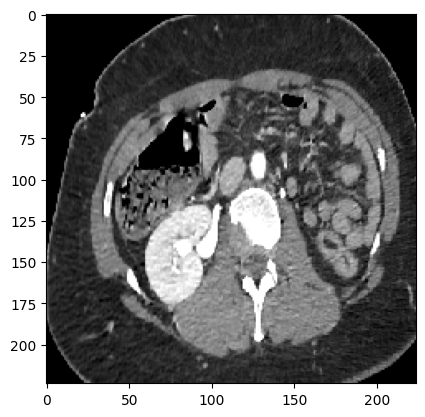

In [94]:
plt.imshow(imgs[:,:,30], cmap='gray')